In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
batch_size = 32
num_workers = 1

# NOTE we can change the input channel from 3 to 1 here
transform = transforms.Compose([transforms.Resize((128,128)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()
                               ])
train_data = torchvision.datasets.ImageFolder('regression_new_UTKFace/train', transform=transform)
val_data = torchvision.datasets.ImageFolder('regression_new_UTKFace/validation', transform=transform)
test_data = torchvision.datasets.ImageFolder('regression_new_UTKFace/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print(len(train_loader), len(val_loader), len(test_loader))

521 112 110


In [3]:
class AgeNet(nn.Module):
    def __init__(self):
        super(AgeNet, self).__init__()
        self.name = "AgeNet"
        # input layer is 1*128*128
        self.conv1 = nn.Conv2d(1, 5, 5, stride = 1, padding = 2) # output layer is 5*64*64
        self.pool1 = nn.MaxPool2d(4, 4) # output layer is 5*32*32
        self.conv2 = nn.Conv2d(5, 10, 5, stride = 1, padding = 2) # output layer is 10*32*32
        self.pool2 = nn.MaxPool2d(2, 2)  # output layer is 10*16*16
        self.conv3 = nn.Conv2d(10, 20, 5, stride = 1, padding = 2) # output layer is 20*16*16
        self.fc1 = nn.Linear(20*16*16, 128) # outputing 128
        self.fc2 = nn.Linear(128, 90)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 20*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [4]:
# function that calculates the accuracy
def get_accuracy(model, loader, batch_size):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        #############################################
        #To Enable GPU Usage
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()  
        #############################################
        output = model(imgs)
        prob = F.softmax(output, dim=1)
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# function that gets the validation loss
def get_val_loss(model, criterion, val_loader):
    total_loss = 0
    total = 0
    for imgs, labels in iter(val_loader):
        imgs = torch.from_numpy(imgs.detach().numpy())
        #############################################
        #To Enable GPU Usage
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################
        output = model(imgs)             # forward pass
        prob = F.softmax(output, dim=1)
        loss = criterion(output, labels) # compute the total loss
        total_loss += loss.item()
        total += imgs.shape[0]
    return total_loss / total

# function to train the model
def train(model, train_data, batch_size=32, lr=0.01, num_epochs=1, is_overfit=False):
#     torch.manual_seed(2) # set the random seed
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    if is_overfit:
        overfit_loader = torch.utils.data.DataLoader(overfit_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    criterion = nn.CrossEntropyLoss() # use cross entropy loss function
    optimizer = optim.Adam(model.parameters(), lr) # use adam optimizer

    iters, train_acc, train_loss, val_acc, val_loss = [], [], [], [], []
    best_val_loss = 99999999

    # training
    print("training now...")
    
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs = torch.from_numpy(imgs.detach().numpy())
            #############################################
            #To Enable GPU Usage
            if use_cuda:
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################
            output = model(imgs)             # forward pass
            prob = F.softmax(output, dim=1)
            loss = criterion(output, labels) # compute the total loss
            loss = loss.float()
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        this_train_loss = float(loss)/batch_size
        train_loss.append(this_train_loss)    # compute *average* loss
        this_val_loss = get_val_loss(model, criterion, val_loader)
        val_loss.append(this_val_loss)
        
        if is_overfit:
            training_accuracy = get_accuracy(model, overfit_loader, batch_size)
            train_acc.append(training_accuracy)
            validation_accuracy = get_accuracy(model, overfit_loader, batch_size)
            val_acc.append(validation_accuracy)
        else:
            training_accuracy = get_accuracy(model, train_loader, batch_size)
            train_acc.append(training_accuracy) # compute training accuracy
            validation_accuracy = get_accuracy(model, val_loader, batch_size)
            val_acc.append(validation_accuracy)
        
        if this_val_loss < best_val_loss: # update best validation loss
            best_val_loss = this_val_loss
            torch.save(model.state_dict(), 'models/model7.pth') # save the best model
        
        print("Epoch {} - Training Accuracy: {}, Validation Accuracy: {}".format(
            epoch, training_accuracy, validation_accuracy))
#         print("Epoch {} - Training Loss: {}, Validation Loss: {}".format(
#             epoch, this_train_loss, this_val_loss))
        n += 1

    # plotting
    plt.title("Loss Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
#     print("Final Training Loss: {}".format(train_acc[-1]))
#     print("Final Validation Loss: {}".format(val_acc[-1]))

In [5]:
use_cuda = torch.cuda.is_available()

training now...
Epoch 0 - Training Accuracy: 0.13407385169618732, Validation Accuracy: 0.1319268635724332
Epoch 1 - Training Accuracy: 0.1493845691984389, Validation Accuracy: 0.14739803094233475
Epoch 2 - Training Accuracy: 0.16067247072951066, Validation Accuracy: 0.15049226441631505
Epoch 3 - Training Accuracy: 0.1668567997598319, Validation Accuracy: 0.15246132208157526
Epoch 4 - Training Accuracy: 0.18558991293905733, Validation Accuracy: 0.16061884669479606
Epoch 5 - Training Accuracy: 0.18997298108676072, Validation Accuracy: 0.14627285513361463
Epoch 6 - Training Accuracy: 0.20462323626538578, Validation Accuracy: 0.15583684950773558
Epoch 7 - Training Accuracy: 0.21987391173821674, Validation Accuracy: 0.14486638537271448
Epoch 8 - Training Accuracy: 0.23908736115280696, Validation Accuracy: 0.15724331926863572
Epoch 9 - Training Accuracy: 0.25938156709696786, Validation Accuracy: 0.15414908579465542
Epoch 10 - Training Accuracy: 0.27733413389372563, Validation Accuracy: 0.148

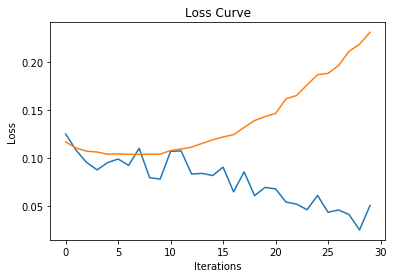

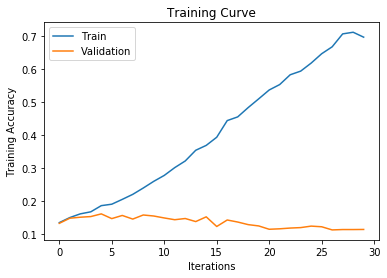

Final Training Accuracy: 0.6968477934554188
Final Validation Accuracy: 0.11336146272855134


In [6]:
model = AgeNet()
# use_cuda = 0
if use_cuda:
    model = model.cuda()
train(model, train_data, batch_size=32, lr=0.001, num_epochs=30)

tensor([4.1159e-05, 5.4845e-04, 2.1863e-04, 1.4925e-04, 3.1421e-04, 2.1054e-04,
        1.1387e-04, 2.5567e-04, 1.9246e-05, 4.4031e-05, 5.0287e-06, 7.0544e-05,
        8.4215e-06, 3.2197e-06, 2.3667e-06, 1.0556e-05, 2.3125e-05, 2.5512e-05,
        1.1729e-04, 5.1584e-05, 7.9513e-05, 8.2893e-05, 3.0600e-04, 2.0430e-04,
        1.2886e-04, 4.4589e-04, 3.5435e-05, 1.6548e-04, 3.6992e-04, 4.2710e-04,
        4.1704e-04, 1.5019e-04, 6.8072e-04, 1.5555e-04, 1.4043e-03, 2.3235e-04,
        1.3787e-03, 4.3909e-04, 3.6113e-04, 2.4358e-03, 6.0433e-04, 1.5540e-03,
        2.0518e-03, 2.4563e-03, 3.5350e-04, 4.8273e-03, 1.9312e-03, 2.0804e-03,
        1.1303e-02, 1.3901e-02, 4.5875e-03, 1.6571e-02, 4.6838e-03, 2.1948e-02,
        4.7104e-03, 2.4189e-04, 3.9499e-02, 2.7296e-02, 1.4889e-02, 1.9234e-02,
        7.3628e-03, 9.0614e-02, 1.2886e-02, 4.4763e-02, 3.4436e-02, 1.6169e-02,
        5.4325e-04, 2.4115e-02, 3.0355e-03, 6.0610e-02, 1.5183e-02, 5.3939e-03,
        3.2169e-02, 4.7223e-03, 5.1389e-

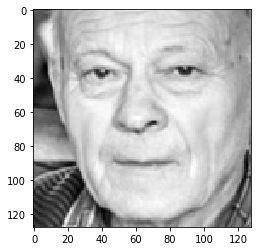

In [11]:
# Output result of one of the test images
myiter = iter(test_loader)
imgs, labels = myiter.next()

final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model7.pth'))
final_model.eval()
output = final_model(imgs)
prob = F.softmax(output, dim=1)
pred = prob.max(1, keepdim=True)[1]
print(prob[0])
print("Predicted Age Group:", pred[0].item())
print("Actual Age Group:", labels[0].item())

# convert to numpy to display image
imgs = imgs.detach().numpy()
imgs = imgs.squeeze() # (128,128,1) -> (128,128)
plt.imshow(imgs[0], cmap=plt.get_cmap('gray'))

tensor([4.2524e-03, 4.5465e-03, 1.0359e-03, 3.7008e-03, 1.1215e-03, 6.6815e-03,
        6.5738e-03, 1.8943e-03, 3.2197e-03, 1.9097e-03, 1.1758e-03, 1.5416e-03,
        1.2529e-03, 7.4649e-04, 1.1400e-03, 1.7369e-03, 2.7887e-03, 1.0004e-02,
        2.3631e-02, 1.0860e-02, 2.3447e-02, 8.9347e-03, 1.1172e-03, 1.0592e-02,
        2.7410e-02, 1.6990e-02, 4.5499e-03, 7.7353e-02, 3.6581e-02, 4.7498e-02,
        4.5957e-02, 1.7648e-02, 3.2665e-02, 9.5428e-04, 3.3452e-02, 3.8590e-02,
        3.0039e-02, 1.2692e-02, 1.9414e-02, 7.9558e-02, 2.1948e-02, 2.8329e-02,
        1.9168e-02, 2.3352e-02, 1.0918e-03, 4.2313e-02, 1.7437e-02, 1.5413e-02,
        5.3183e-03, 2.0739e-02, 8.9551e-03, 2.1781e-02, 7.5391e-03, 1.2934e-02,
        3.5843e-03, 2.5913e-03, 1.1065e-02, 8.2927e-03, 1.2879e-02, 6.7985e-04,
        9.5935e-04, 9.6831e-03, 1.0329e-03, 3.8718e-03, 3.6477e-03, 2.2466e-03,
        3.3861e-03, 3.3944e-03, 1.6198e-03, 4.2268e-04, 2.7832e-04, 4.6299e-04,
        4.5714e-03, 5.5756e-03, 1.4139e-

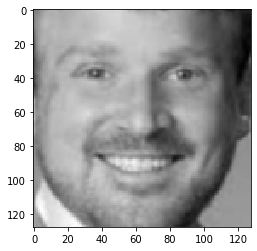

In [12]:
# Output result of one of the test images
myiter = iter(test_loader)
imgs, labels = myiter.next()

final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model7.pth'))
final_model.eval()
output = final_model(imgs)
prob = F.softmax(output, dim=1)
pred = prob.max(1, keepdim=True)[1]
print(prob[0])
print("Predicted Age Group:", pred[0].item())
print("Actual Age Group:", labels[0].item())

# convert to numpy to display image
imgs = imgs.detach().numpy()
imgs = imgs.squeeze() # (128,128,1) -> (128,128)
plt.imshow(imgs[0], cmap=plt.get_cmap('gray'))

tensor([6.2214e-05, 9.4807e-05, 6.1117e-05, 5.4610e-05, 9.8634e-05, 7.0381e-05,
        5.6860e-05, 1.1709e-04, 1.9725e-05, 4.1119e-05, 1.0215e-05, 6.0259e-05,
        1.8159e-05, 6.7796e-06, 9.0372e-06, 3.8306e-05, 7.7729e-05, 4.4111e-05,
        2.4396e-04, 1.3745e-04, 1.4696e-04, 1.4829e-04, 1.9144e-04, 4.1075e-04,
        1.5893e-04, 6.3418e-04, 6.9718e-05, 2.4898e-04, 9.0699e-04, 6.1734e-04,
        5.9729e-04, 3.3112e-04, 7.7979e-04, 7.1664e-05, 2.2175e-03, 3.7154e-04,
        9.9901e-04, 9.4928e-04, 3.7882e-04, 2.3297e-03, 5.5502e-04, 1.0020e-03,
        3.3951e-03, 1.6027e-03, 1.2451e-04, 5.4653e-03, 3.4749e-03, 3.3100e-03,
        1.2569e-02, 1.3564e-02, 7.2862e-03, 1.6617e-02, 5.2968e-03, 3.9494e-02,
        5.4221e-03, 1.4846e-04, 2.8089e-02, 3.1585e-02, 1.9620e-02, 2.3788e-02,
        1.9156e-02, 6.0070e-02, 1.9499e-02, 2.9342e-02, 2.3938e-02, 1.8922e-02,
        1.7767e-04, 2.8133e-02, 1.1549e-02, 4.5363e-02, 3.4589e-02, 1.1972e-02,
        5.7423e-02, 1.3721e-02, 1.0703e-

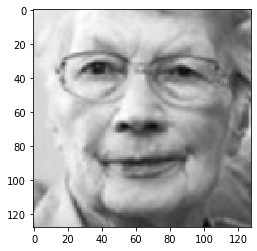

In [14]:
# Output result of one of the test images
myiter = iter(test_loader)
imgs, labels = myiter.next()

final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model7.pth'))
final_model.eval()
output = final_model(imgs)
prob = F.softmax(output, dim=1)
pred = prob.max(1, keepdim=True)[1]
print(prob[0])
print("Predicted Age Group:", pred[0].item())
print("Actual Age Group:", labels[0].item())

# convert to numpy to display image
imgs = imgs.detach().numpy()
imgs = imgs.squeeze() # (128,128,1) -> (128,128)
plt.imshow(imgs[0], cmap=plt.get_cmap('gray'))

tensor([7.8372e-01, 3.0522e-05, 1.6662e-05, 7.0670e-05, 5.6511e-06, 4.3409e-05,
        1.4167e-06, 6.3301e-07, 1.7385e-06, 1.1410e-06, 2.5751e-08, 1.3418e-01,
        2.1398e-06, 2.7242e-06, 3.4015e-07, 4.3774e-07, 1.2357e-06, 1.1346e-06,
        5.4404e-06, 2.3925e-07, 1.7662e-06, 3.7118e-07, 5.0125e-02, 8.7058e-07,
        4.3717e-07, 4.3254e-07, 1.9243e-08, 1.4138e-06, 6.0933e-07, 1.9256e-07,
        3.6153e-07, 4.4070e-07, 1.8768e-07, 1.8030e-02, 2.3058e-07, 1.7162e-07,
        1.9763e-07, 2.1671e-08, 4.8243e-08, 1.7890e-07, 3.8024e-08, 7.7739e-09,
        8.7834e-09, 7.1174e-08, 4.7921e-03, 4.7695e-07, 3.1578e-08, 4.1260e-08,
        6.3525e-08, 1.5046e-08, 2.9501e-07, 6.7874e-08, 2.6105e-08, 1.2010e-07,
        2.1146e-09, 1.8367e-03, 3.0363e-07, 1.6530e-06, 5.8357e-09, 2.3118e-09,
        3.5121e-08, 1.0123e-06, 2.0150e-07, 6.0464e-08, 2.4135e-07, 2.0508e-08,
        6.6490e-03, 2.9626e-08, 2.6152e-10, 1.7188e-09, 5.2919e-08, 5.8238e-09,
        2.1269e-08, 7.8973e-09, 1.4969e-

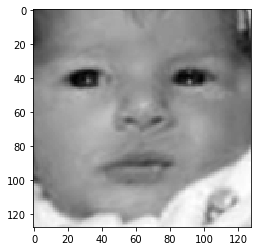

In [15]:
# Output result of one of the test images
myiter = iter(test_loader)
imgs, labels = myiter.next()

final_model = AgeNet()
final_model.load_state_dict(torch.load('models/model7.pth'))
final_model.eval()
output = final_model(imgs)
prob = F.softmax(output, dim=1)
pred = prob.max(1, keepdim=True)[1]
print(prob[0])
print("Predicted Age Group:", pred[0].item())
print("Actual Age Group:", labels[0].item())

# convert to numpy to display image
imgs = imgs.detach().numpy()
imgs = imgs.squeeze() # (128,128,1) -> (128,128)
plt.imshow(imgs[0], cmap=plt.get_cmap('gray'))